# Assignment 10

### <span style="color:chocolate"> Submission requirements </span>

Your work will not be graded if your notebook doesn't include output. In other words, <span style="color:red"> make sure to rerun your notebook before submitting to Gradescope </span> (Note: if you are using Google Colab: go to Edit > Notebook Settings  and uncheck Omit code cell output when saving this notebook, otherwise the output is not printed).

Additional points may be deducted if these requirements are not met:
    
* Comment your code;
* Each graph should have a title, labels for each axis, and (if needed) a legend. Each graph should be understandable on its own;
* Try and minimize the use of the global namespace (meaning, keep things inside functions).

---

#### ``Objectives``
1. Implement a CNN to detect diabetic retinopathy (DR) from retina images taken using fundus photography under a variety of imaging conditions.
2. Improve generalization performance and reduce overfitting using **image transformation** and **data augmentation** techniques.

#### ``Motivation``

Diabetic retinopathy (DR) is an eye condition that  affects blood vessels in the retina. It can cause vision loss and blindness in people who have diabetes. Screening for DR allows earlier and more effective treatment options for millions of people.

#### ``Data``

In this assignment you will use a small dataset of retina images (`Download` links: [images](https://drive.google.com/drive/folders/1sdfUC64Un1iwuiHEehcbijxB54OhU_nd?usp=sharing) and [labels](https://drive.google.com/drive/folders/1MOlSJBZg7L1HtG5vHPt77ighRvQaGfDg?usp=sharing)). You will **build** and **train** a **CNN model** to predict whether or not to refer a patient for DR treatment using binarized severity of DR in patients: no referral if {No DR, mild} and referral if {moderate, severe, and proliferate DR}.


<u>Note</u>: the original dataset is hosted by Kaggle [[Source]](https://www.kaggle.com/c/aptos2019-blindness-detection/).

Import the necessary libraries and make sure to replace IMAGE_PATH and LABEL_PATH with the path to the directories where you saved the data.

---
### Step 1: Import libraries

In [1]:
# standard
import pandas as pd
import numpy as np
import random
import os

# tf and keras
import tensorflow as tf
from tensorflow.keras.preprocessing.image import ImageDataGenerator, array_to_img, img_to_array, load_img
from keras import models
from keras import layers

# sklearn
from sklearn.metrics import accuracy_score
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay

# plots
import seaborn as sns
import matplotlib.pyplot as plt

random.seed(2)
%matplotlib inline

# FILL IN CODE HERE #
IMAGE_PATH = 'CNN_DiabeticRetinopathy/CNN_images/' # replace with your path
LABEL_PATH = 'CNN_DiabeticRetinopathy/LABELS/' # replace with your path

2024-11-08 02:41:46.970367: E external/local_xla/xla/stream_executor/cuda/cuda_fft.cc:485] Unable to register cuFFT factory: Attempting to register factory for plugin cuFFT when one has already been registered
2024-11-08 02:41:46.992138: E external/local_xla/xla/stream_executor/cuda/cuda_dnn.cc:8454] Unable to register cuDNN factory: Attempting to register factory for plugin cuDNN when one has already been registered
2024-11-08 02:41:46.998683: E external/local_xla/xla/stream_executor/cuda/cuda_blas.cc:1452] Unable to register cuBLAS factory: Attempting to register factory for plugin cuBLAS when one has already been registered
2024-11-08 02:41:47.019214: I tensorflow/core/platform/cpu_feature_guard.cc:210] This TensorFlow binary is optimized to use available CPU instructions in performance-critical operations.
To enable the following instructions: AVX2 FMA, in other operations, rebuild TensorFlow with the appropriate compiler flags.
2024-11-08 02:41:48.060540: W tensorflow/compiler/tf2

At this point, you may ask yourself what the best model that fits this data is. First, you will want to read through the data description in Kaggle (see the link to the original dataset above). Understanding what you are working with challenges you to write preprocessing code that uncovers your data's most helpful information.

---
#### <span style="color:chocolate"> Exercise 1 (10 points) </span>

Read the data description from Kaggle and list (a) the source of images and (b) the labeling procedure.

*Written answer*:
- (a.) The images are retina images captured using fundus photography, which is a specialized type of medical imaging for the retina. These images were collected from multiple clinics, with images captured under different conditions (e.g., various lighting, exposure levels, and camera types).
- (b.) Each image has been labeled by a clinician, who assessed the severity of diabetic retinopathy. The severity is rated on a scale from 0 to 4:
    - 0 - No DR
    - 1 - Mild DR
    - 2 - Moderate DR
    - 3 - Severe DR
    - 4 - Proliferative DR
    
    The labels represent the extent of damage observed in the retina and correlate with the need for intervention:
Mild cases may not require immediate intervention, while moderate to severe cases are more likely to require it.

---
### Step 2: Data ingestion

Let's load the 2D images and their corresponding labels.

``labels``

In [2]:
labels = pd.read_csv(
    LABEL_PATH + 'labels.csv'
)

print('Shape of labels:', labels.shape)
print('Unique diagnosis codes:', np.sort(labels.diagnosis.unique()))
labels.head()

Shape of labels: (200, 2)
Unique diagnosis codes: [0 1 2 3 4]


,id_code,diagnosis
0,000c1434d8d7,2
1,0024cdab0c1e,1
2,0083ee8054ee,4
3,00a8624548a9,2
4,00b74780d31d,2


There are 200 training images corrresponding to 5 different diabetic retinopathy (DR) diagnosis codes: 

* No DR (0)
* mild (1)
* moderate (2)
* severe (3)
* proliferate DR (4)


``images``

In [3]:
images = []

for idx, img in enumerate(os.listdir(IMAGE_PATH)):
    img = load_img(
    IMAGE_PATH + img)
    images.append(img)

---
### Step 3: Exploratory Data Analysis (EDA)

#### <span style="color:chocolate"> Exercise 2 (10 points) </span>

Plot a histogram for the five classes of DR. Are the classes balanced?


Note: It's acceptable to plot the distribution of classes before splitting your data into training, validation, and test sets. Doing so does not compromise the "blindness" of the test data. Why? `Plotting the distribution of classes before splitting the data into training, validation, and test sets is acceptable because it provides an overview of class imbalance in the dataset as a whole. This action does not involve looking at specific instances in the test set or using them in model training, so it maintains the "blindness" of the test data.`

/home/vanel/anaconda3/lib/python3.11/site-packages/seaborn/_oldcore.py:1119: FutureWarning: use_inf_as_na option is deprecated and will be removed in a future version. Convert inf values to NaN before operating instead.
  with pd.option_context('mode.use_inf_as_na', True):


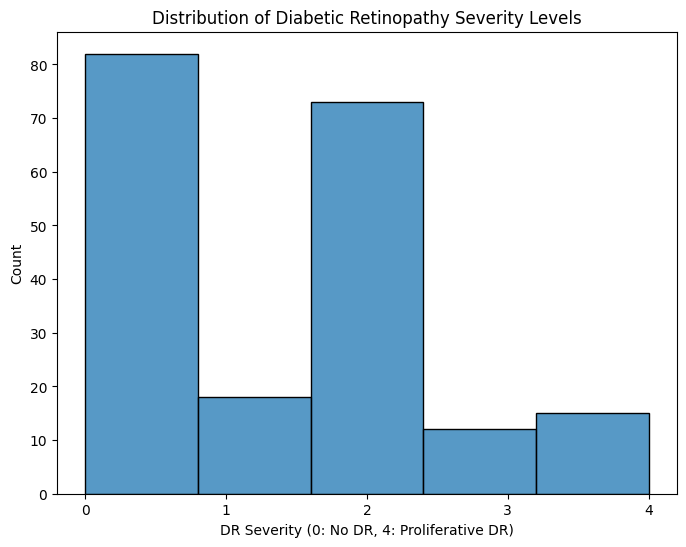

In [4]:
# YOUR CODE HERE
# Plot a histogram for the distribution of DR classes
plt.figure(figsize=(8, 6))
sns.histplot(labels['diagnosis'], bins=5, kde=False)
plt.title('Distribution of Diabetic Retinopathy Severity Levels')
plt.xlabel('DR Severity (0: No DR, 4: Proliferative DR)')
plt.xticks(range(5))
plt.ylabel('Count')
plt.show()


Comment on class balance: [`From the histogram, we can observe a significant imbalance in the distribution of diabetic retinopathy severity levels. The "No DR" (class 0) and "Moderate DR" (class 2) categories contain the highest counts, while "Mild DR" (class 1), "Severe DR" (class 3), and "Proliferative DR" (class 4) are underrepresented. This imbalance could lead to biases in the model, as it might be inclined to favor the more frequent classes.`].

#### <span style="color:chocolate"> Exercise 3 (10 points) </span>

Print 8 images from the data. What can you say about the size, focus/orientation of these images?

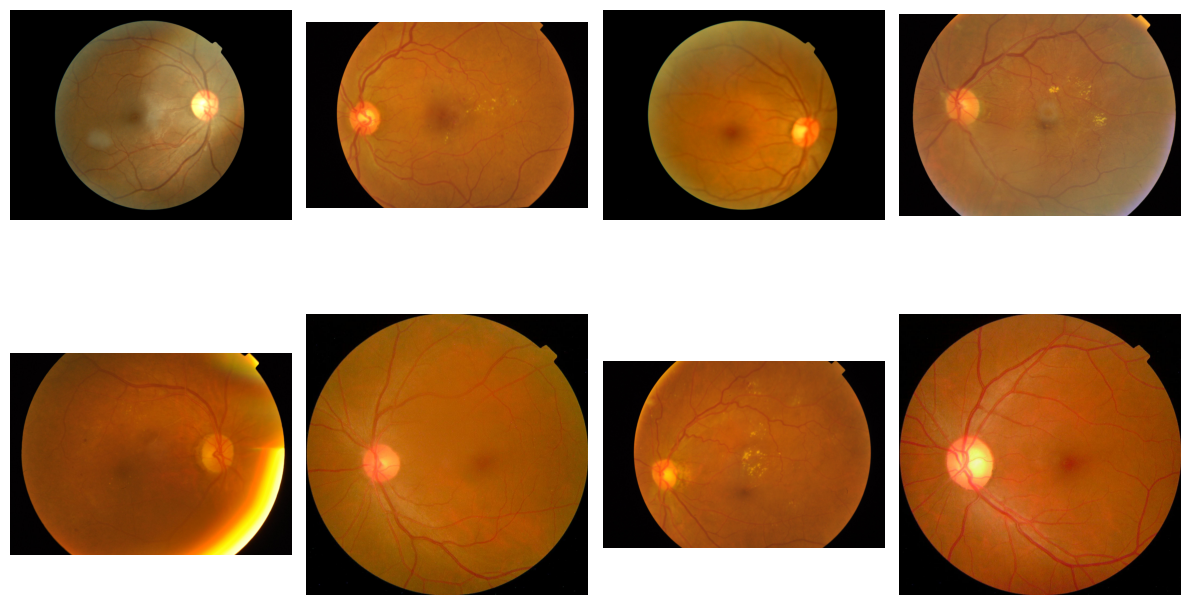

In [5]:
# FILL IN CODE HERE #

plt.figure(figsize=(12, 8))
for i in range(8):
    plt.subplot(2, 4, i + 1)  # Arrange images in a 2x4 grid
    plt.imshow(images[i])
    plt.axis('off')  # Hide axes for a cleaner look

plt.tight_layout()
plt.show()


Comment on the size, focus/orientation of the 8 images: [
1. The images are approximately circular and centered within a black background. They appear to be of varying sizes relative to the frame, indicating differences in image capture or cropping. The orientation seems consistent across images, with the optic disc generally located towards the right side in each image.

2. Some images are clear and well-focused, while others appear slightly blurred or have reduced contrast. This variability in focus could impact the model’s ability to detect features consistently and may require preprocessing steps for enhancement.

3. The brightness and color tones vary between images, with some appearing darker and others having brighter spots. Variations in lighting and exposure can be seen, which may be due to different imaging conditions or equipment.
]

---
### Step 4: Data preprocessing

First, we will correct for class imbalance. Note that imbalanced data is common in healthcare, and it happens because some diseases are rare. The presence of imbalanced data hampers the detection of rare events as most classification methods implicitly assume a similar occurrence of classes and are designed to maximize the overall classification accuracy.

We will correct for class imbalance in two ways:

  * First, we will binarize the DR diagnosis as follows:
     - 'no refer' are {No DR, mild}
     - 'refer' are {Moderate, Severe, Proliferate}


  * Second, we'll only take 80 random samples from the 'no refer' class and 80 from the 'refer' class.

It is a crude method to deal with imbalanced data, but it will be good enough for this homework. 

In [6]:
np.random.seed(1234)

no_refer = labels[labels.diagnosis.isin((0,1))]
refer = labels[labels.diagnosis.isin((2,3,4))]

# randomly draw 80 images from each classes
temp_no_refer = list(np.random.choice(
    no_refer.id_code,
    size=80,
    replace=False
))

temp_refer = list(np.random.choice(
    refer.id_code,
    size=80,
    replace=False
))

Next, we will use the ``preprocess_data_part1()`` function defined below to generate lists of images and labels (images_mini and y_mini) based on the values in the temp_no_refer and temp_refer lists. Note that the size of the image is set to (224, 224).

In [7]:
def preprocess_data_part1(IMAGE_PATH, LABEL_PATH, temp_no_refer, temp_refer):
    """ Generate lists of images and labelsbased on temp_no_refer and temp_refer lists
    
    Params:
    -------
    IMAGE_PATH (str): path to directory with images.
    LABEL_PATH (str): path to directory with labels.
    temp_no_refer (str): list of labels for the no refer category
    temp_refer (str): list of labels for the refer category
    
    Returns:
    --------
    images_mini  (np.ndarray): Images of shape (N, 224, 224, 3)
    y_mini (np.ndarray): Labels of shape (N,)    
    """
    y_mini = []
    images_mini = []

    # create lists of images and labels `images_mini` and `y_mini` 
    # based on temp_no_refer and temp_refer selections
    for idx, img in enumerate(os.listdir(IMAGE_PATH)):
        # read labels
        if img.split('.')[0] in temp_no_refer:
                y_mini.append(0)
        elif img.split('.')[0] in temp_refer:
                y_mini.append(1)
        else:
            continue

        
        # read image
        img = load_img(
            IMAGE_PATH + img,
            target_size=(224, 224)
        )
        
        # transform image to array
        img = img_to_array(img)

        # append to images
        images_mini.append(img)

    # stack images and trasnform to array
    images_mini = np.stack(images_mini)
    y_mini = np.array(y_mini).flatten() 
    
    return images_mini, y_mini

In [8]:
# generate images and labels based on preprocess_data_part1() function
images_mini, y_mini = preprocess_data_part1(
    IMAGE_PATH, LABEL_PATH, temp_no_refer, temp_refer
)

print(f"images_mini shape {images_mini.shape}")
print(f"y_mini shape {y_mini.shape}")

images_mini shape (160, 224, 224, 3)
y_mini shape (160,)


#### <span style="color:chocolate"> Exercise 4 (20 points) </span>

Create train, validation, and test data. Implement the `preprocess_data_part2()` function according to the following guidelines:

1. shuffle images and labels before splitting the data

2. use a (0.6,0.2,0.2)train/validation/test set split

3. perform image transformation and augmentation, as follows:
    * Applied on training set only:
         - create additional copies (augmentations) of the training images by flipping left right each image (Hint: use the method available in the tf.image module).
         - concatenate the augmented images to the original training images. Note that the train set should be double in size after data augmentation, i.e., 192 images and labels.
    * Applied on training, validation, and test sets:
        - rescale images by dividing each pixel by 255.0

Reason for doing image augmentation: The quantity and diversity of data gathered significantly impact the results of a CNN model. One can use augmentations to artificially inflate the training dataset by warping the original data so that their label does not change. These augmentations can significantly improve learning results without collecting new data.

In [9]:
def preprocess_data_part2(images, labels, splits):
    """ Split data into train, validation and test sets; apply transformaions and augmentations
    
    Params:
    -------
    images  (np.ndarray): Images of shape (N, 224, 224, 3)
    labels (np.ndarray): Labels of shape (N,)   
    splits (tuple): 3 values summing to 1 defining split of train, validation and test sets
    
    Returns:
    --------
    X_train (np.ndarray): Train images of shape (N_train, 224, 224, 3)
    y_train (np.ndarray): Train labels of shape (N_train,)
    X_val (np.ndarray): Val images of shape (N_val, 224, 224, 3)
    y_val (np.ndarray): Val labels of shape (N_val,)
    X_test (np.ndarray): Test images of shape (N_test, 224, 224, 3)
    y_test (np.ndarray): Test labels of shape (N_test,)
    
    """
    
    # NOTE: Each time you run this cell, you'll re-shuffle the data. The ordering will be the same due to the random seed generator 
    tf.random.set_seed(1234)
    np.random.seed(1234)
    
    # shuffle data
    # FILL IN CODE HERE #
    indices = np.random.permutation(len(images))
    images = images[indices]
    labels = labels[indices]
    
    # create data splits (training, val, and test sets)
    # FILL IN CODE HERE #
    total_samples = len(images)
    train_size = int(total_samples * splits[0])
    val_size = int(total_samples * splits[1])
    test_size = total_samples - train_size - val_size #remaining samples

    # Split data into train, validation, and test sets
    X_train, y_train = images[:train_size], labels[:train_size]
    X_val, y_val = images[train_size:train_size + val_size], labels[train_size:train_size + val_size]
    X_test, y_test = images[train_size + val_size:], labels[train_size + val_size:]
    
    # image augmentation (random flip) on training data
    X_train_augm = tf.image.flip_left_right(X_train)

    # concatenate original X_train and augmented X_train_augm data
    X_train = np.concatenate([X_train, X_train_augm], axis=0)

    # concatenate y_train (note the label is preserved)
    y_train_augm = y_train
    y_train = tf.concat([y_train, y_train_augm],axis=0)

    # shuffle X_train and y_train, i.e., shuffle two tensors in the same order
    shuffle = tf.random.shuffle(tf.range(tf.shape(X_train)[0], dtype=tf.int32))
    X_train = tf.gather(X_train, shuffle).numpy() # transform X back to numpy array instead of tensor
    y_train = tf.gather(y_train, shuffle).numpy() # transform y back to numpy array instead of tensor

    # Shuffle the augmented training data to mix original and augmented samples
    shuffle_indices = np.random.permutation(len(X_train))
    X_train = X_train[shuffle_indices]
    y_train = y_train[shuffle_indices]

    # rescale training, val, and test images by dividing each pixel by 255.0 
    X_train = X_train / 255.0
    X_val = X_val / 255.0
    X_test = X_test / 255.0
    
    return X_train, y_train, X_val, y_val, X_test, y_test

In [10]:
# define splits
split = (0.6, 0.2, 0.2)

X_train, y_train, X_val, y_val, X_test, y_test = preprocess_data_part2(
    images_mini,
    y_mini,
    split
)

print(f"X_train shape {X_train.shape}")
print(f"y_train shape {y_train.shape}")
print(f"X_val shape {X_val.shape}")
print(f"y_val shape {y_val.shape}")
print(f"X_test shape {X_test.shape}")
print(f"y_test shape {y_test.shape}")

X_train shape (192, 224, 224, 3)
y_train shape (192,)
X_val shape (32, 224, 224, 3)
y_val shape (32,)
X_test shape (32, 224, 224, 3)
y_test shape (32,)


---
### Step 5: Modeling

#### <span style="color:chocolate"> Exercise 5 (20 points) </span>

The objective is to build and train a CNN model to refer patients to doctors based on the severity of DR seen in these images. You are interested in exploring binary classification of 'no refer' and 'refer'.

Implement a CNN classifier according to the following guidelines (let's call this *model_tf*):

1. Implement this model using the TF Keras API.
1. The model receives input images of size 224 x 224 x 3 (that is, the images have three color channels)
2. The input data goes through one convolutional layer that has the following specifications:
    - filters = 12
    - kernel_size = (4 x 4)
    - strides = (1, 1)
    - padding = 'same'
    - data_format = 'channels_last'
    - name = 'conv_1'
    - activation = 'relu'
3. The convolutional layer is followed by a max-pooling layer with pool_size = (2,2). Note: this will reduce the size of the feature maps.
4. The max-pooling layer is followed by a dropout layer with rate = 0.3.
5. The dropout layer is followed by a flattening layer.
6. The last layer of the model is the classification head.
7. Build and compile the model using the Adam optimizer and learning_rate = 0.1. Print summary of the model.
8. Train the model on (X_train, y_train) data for 20 epochs. Add early stopping (Hint: pass the early_stopping implementation below to the fit() method as "callbacks=[early_stopping]").
9. How many parameters does the model have?
10. Generate a plot (for the training and validation data) with the loss values on the y-axis and the epoch number on the x-axis for visualization. Make sure to include axes name and title. Hint: check what the tf.keras.Model.fit() method returns.
11. Evaluate the accuracy of the model on (X_train, y_train) and (X_val, y_val) data. Comment on model performance on training vs. validation datasets. 

In [11]:
# define an instance of the early_stopping class
early_stopping = tf.keras.callbacks.EarlyStopping(
monitor='accuracy', 
verbose=1,
patience=5,
mode='max',
restore_best_weights=True)

Model: "sequential"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ conv_1 (Conv2D)                 │ (None, 224, 224, 12)   │           588 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d (MaxPooling2D)    │ (None, 112, 112, 12)   │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout (Dropout)               │ (None, 112, 112, 12)   │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ flatten (Flatten)               │ (None, 150528)         │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense (Dense)                   │ (None, 1)              │       150,529 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 151,117 (590.30 KB)

 Trainable params: 151,117 (590.30 KB)

 Non-trainable params: 0 (0.00 B)

None
Epoch 1/20
6/6 ━━━━━━━━━━━━━━━━━━━━ 3s 427ms/step - accuracy: 0.5001 - loss: 760.0588 - val_accuracy: 0.5625 - val_loss: 0.6865
Epoch 2/20
6/6 ━━━━━━━━━━━━━━━━━━━━ 2s 357ms/step - accuracy: 0.4992 - loss: 0.6974 - val_accuracy: 0.5625 - val_loss: 0.6854
Epoch 3/20
6/6 ━━━━━━━━━━━━━━━━━━━━ 2s 335ms/step - accuracy: 0.4992 - loss: 0.6998 - val_accuracy: 0.5625 - val_loss: 0.6858
Epoch 4/20
6/6 ━━━━━━━━━━━━━━━━━━━━ 2s 383ms/step - accuracy: 0.4992 - loss: 0.6969 - val_accuracy: 0.5625 - val_loss: 0.6884
Epoch 5/20
6/6 ━━━━━━━━━━━━━━━━━━━━ 2s 372ms/step - accuracy: 0.4992 - loss: 0.6940 - val_accuracy: 0.5625 - val_loss: 0.6930
Epoch 6/20
6/6 ━━━━━━━━━━━━━━━━━━━━ 2s 346ms/step - accuracy: 0.5008 - loss: 0.6933 - val_accuracy: 0.4375 - val_loss: 0.6965
Epoch 6: early stopping
Restoring model weights from the end of the best epoch: 1.


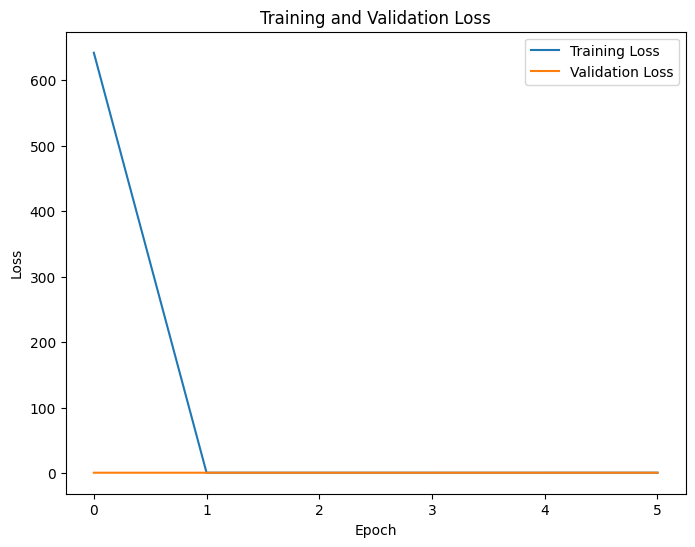

Training Accuracy: 0.50
Validation Accuracy: 0.56


In [12]:

tf.random.set_seed(1234)
np.random.seed(1234)

# initialize model
model_tf = tf.keras.Sequential()

# add convolutional layer
model_tf.add(tf.keras.layers.Conv2D(filters=12, kernel_size=(4,4),strides=(1,1),padding='same', 
                                    data_format='channels_last', activation='relu', name='conv_1')) #,input_shape = (224, 224, 3)

# add max pooling layer 
model_tf.add(tf.keras.layers.MaxPooling2D(pool_size=(2,2)))

# add dropout layer
model_tf.add(tf.keras.layers.Dropout(rate=0.3))

# add a flattening layer
model_tf.add(tf.keras.layers.Flatten())

# add the classification layer
model_tf.add(tf.keras.layers.Dense(1, activation = 'sigmoid'))

# build and compile model
model_tf.build(input_shape=(None, 224, 224, 3))
model_tf.compile(optimizer=tf.keras.optimizers.Adam(learning_rate=0.1),
              loss=tf.keras.losses.BinaryCrossentropy(),
              metrics=['accuracy']) 

# print model_tf summary
print(model_tf.summary())

# train model_tf on (X_train, y_train) data
history = model_tf.fit(X_train, y_train, 
                       epochs = 20,
                       validation_data=(X_val, y_val),
                       callbacks = [early_stopping])

# Plot the loss curves for training and validation
plt.figure(figsize=(8, 6))
plt.plot(history.history['loss'], label='Training Loss')
plt.plot(history.history['val_loss'], label='Validation Loss')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.title('Training and Validation Loss')
plt.legend()
plt.show()

# evaluate the accuracy of model_tf on (X_train, y_train) and (X_val, y_val)

# Evaluate accuracy on the training set
train_loss, train_accuracy = model_tf.evaluate(X_train, y_train, verbose=0)
print(f"Training Accuracy: {train_accuracy:.2f}")

# Evaluate accuracy on the validation set
val_loss, val_accuracy = model_tf.evaluate(X_val, y_val, verbose=0)
print(f"Validation Accuracy: {val_accuracy:.2f}")


How many parameters does *model_tf* have? [`The model has 151,117 parameters`]

Comment on *model_tf* accuracy on training vs. validation data: [`The training and validation accuracies are quite low, with training accuracy at 50% and validation accuracy at 56%. This suggests that the model is struggling to learn meaningful patterns from the data. The discrepancy between the training and validation loss in the plot, with validation loss remaining flat while training loss drops rapidly, may suggest overfitting to some extent, but the model is also likely underfitting.`]

#### <span style="color:chocolate"> Exercise 6 (20 points) </span>

1. Fine-tune the number of hidden layers and the hyperparameters of *model_tf* to determine the setup that yields the most optimal generalization performance. Feel free to explore various model configurations/hyperparameter values.

2. How many parameters does your fine-tuned model have?

3. Evaluate the accuracy of the fine-tuned model on (X_train, y_train) and (X_val, y_val) data. Comment on model performance on training vs. validation datasets.  Is there an improvement compared to the non-fine-tuned version of the model (Exercise 5)?

In [23]:
### YOUR CODE HERE ###

import tensorflow as tf
import numpy as np

def create_improved_cnn_model(learning_rate=0.001):
    """
    Define, compile, and return an improved CNN model for binary classification of diabetic retinopathy.
    
    Parameters:
    -----------
    learning_rate : float, optional, default=0.001
        The learning rate for the Adam optimizer.
    
    Returns:
    --------
    model : tf.keras.Model
        Compiled CNN model.
    """
    # Set random seed for reproducibility
    tf.random.set_seed(1234)
    np.random.seed(1234)

    # Define the model architecture
    model = tf.keras.Sequential([
        # First convolutional block
        tf.keras.layers.Conv2D(32, (3, 3), activation='relu', padding='same', input_shape=(224, 224, 3)),
        tf.keras.layers.MaxPooling2D((2, 2)),
        tf.keras.layers.Dropout(0.20),

        # Second convolutional block
        tf.keras.layers.Conv2D(64, (3, 3), activation='relu', padding='same'),
        tf.keras.layers.MaxPooling2D((2, 2)),
        tf.keras.layers.Dropout(0.20),

        # Third convolutional block
        tf.keras.layers.Conv2D(128, (3, 3), activation='relu', padding='same'),
        tf.keras.layers.MaxPooling2D((2, 2)),
        tf.keras.layers.Dropout(0.20),

        # Fourth convolutional block
        tf.keras.layers.Conv2D(256, (3, 3), activation='relu', padding='same'),
        tf.keras.layers.MaxPooling2D((2, 2)),
        tf.keras.layers.Dropout(0.20),

        # Global average pooling layer
        tf.keras.layers.GlobalAveragePooling2D(),

        # Fully connected classification layer
        tf.keras.layers.Dense(1, activation='sigmoid')
    ])

    # Compile the model with the specified learning rate
    model.compile(optimizer=tf.keras.optimizers.Adam(learning_rate=learning_rate),
                  loss=tf.keras.losses.BinaryCrossentropy(),
                  metrics=['accuracy'])
    
    # Print model summary
    model.summary()
    
    return model


In [24]:
# Initialize the model
model = create_improved_cnn_model(learning_rate=0.001)

# Define early stopping to monitor validation loss and stop if it doesn't improve
early_stopping = tf.keras.callbacks.EarlyStopping(
    monitor='val_loss',
    patience=5,
    restore_best_weights=True,
    verbose=1
)

# Train the model on (X_train, y_train) with validation on (X_val, y_val)
history = model.fit(
    X_train, y_train,
    epochs=30,                # Set a high number of epochs; early stopping will handle stopping
    validation_data=(X_val, y_val),
    callbacks=[early_stopping],
    batch_size=16
)


Model: "sequential_3"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ conv2d_8 (Conv2D)               │ (None, 224, 224, 32)   │           896 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_9 (MaxPooling2D)  │ (None, 112, 112, 32)   │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_9 (Dropout)             │ (None, 112, 112, 32)   │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_9 (Conv2D)               │ (None, 112, 112, 64)   │        18,496 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_10 (MaxPooling2D) │ (None, 56, 56, 64)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_10 (Dropout)            │ (None, 56, 56, 64)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_10 (Conv2D)              │ (None, 56, 56, 128)    │        73,856 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_11 (MaxPooling2D) │ (None, 28, 28, 128)    │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_11 (Dropout)            │ (None, 28, 28, 128)    │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_11 (Conv2D)              │ (None, 28, 28, 256)    │       295,168 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_12 (MaxPooling2D) │ (None, 14, 14, 256)    │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_12 (Dropout)            │ (None, 14, 14, 256)    │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ global_average_pooling2d_2      │ (None, 256)            │             0 │
│ (GlobalAveragePooling2D)        │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_3 (Dense)                 │ (None, 1)              │           257 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 388,673 (1.48 MB)

 Trainable params: 388,673 (1.48 MB)

 Non-trainable params: 0 (0.00 B)

Epoch 1/30
12/12 ━━━━━━━━━━━━━━━━━━━━ 14s 1s/step - accuracy: 0.4650 - loss: 0.7185 - val_accuracy: 0.4375 - val_loss: 0.6937
Epoch 2/30
12/12 ━━━━━━━━━━━━━━━━━━━━ 13s 1s/step - accuracy: 0.4928 - loss: 0.6938 - val_accuracy: 0.4375 - val_loss: 0.6935
Epoch 3/30
12/12 ━━━━━━━━━━━━━━━━━━━━ 12s 1s/step - accuracy: 0.4876 - loss: 0.6930 - val_accuracy: 0.5938 - val_loss: 0.6927
Epoch 4/30
12/12 ━━━━━━━━━━━━━━━━━━━━ 13s 1s/step - accuracy: 0.6343 - loss: 0.6914 - val_accuracy: 0.5625 - val_loss: 0.6864
Epoch 5/30
12/12 ━━━━━━━━━━━━━━━━━━━━ 14s 1s/step - accuracy: 0.5702 - loss: 0.6833 - val_accuracy: 0.5625 - val_loss: 0.6524
Epoch 6/30
12/12 ━━━━━━━━━━━━━━━━━━━━ 12s 1s/step - accuracy: 0.7106 - loss: 0.6445 - val_accuracy: 0.7812 - val_loss: 0.5421
Epoch 7/30
12/12 ━━━━━━━━━━━━━━━━━━━━ 12s 973ms/step - accuracy: 0.7800 - loss: 0.5689 - val_accuracy: 0.8125 - val_loss: 0.4466
Epoch 8/30
12/12 ━━━━━━━━━━━━━━━━━━━━ 12s 1s/step - accuracy: 0.8358 - loss: 0.4827 - val_accuracy: 0.9688 - val_lo

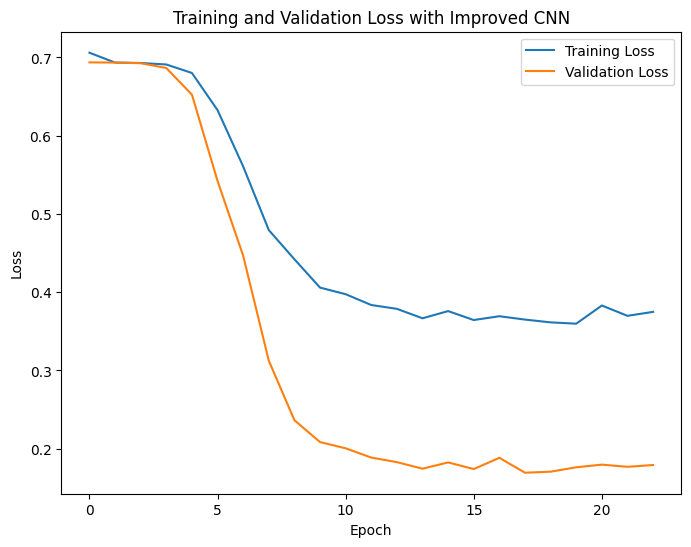

Training Accuracy: 0.85
Validation Accuracy: 0.97


In [25]:
# Plot the loss curves for training and validation
plt.figure(figsize=(8, 6))
plt.plot(history.history['loss'], label='Training Loss')
plt.plot(history.history['val_loss'], label='Validation Loss')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.title('Training and Validation Loss with Improved CNN')
plt.legend()
plt.show()

# Evaluate accuracy on the training set
train_loss, train_accuracy = model.evaluate(X_train, y_train, verbose=0)
print(f"Training Accuracy: {train_accuracy:.2f}")

# Evaluate accuracy on the validation set
val_loss, val_accuracy = model.evaluate(X_val, y_val, verbose=0)
print(f"Validation Accuracy: {val_accuracy:.2f}")


How many parameters does your fine-tuned model have? [`The new fine-tuned model has 388,673 parameters`]

Comment on accuracy of the fine-tuned model on training vs. validation performance. Is there an improvement over the non-fine-tuned version? [`The validation accuracy is high at 97%, which is substantially better than the initial model’s performance. This indicates that the model has learned features that generalize well to unseen data, addressing the issue of poor generalization in the first version. The training accuracy of 85% is lower than the validation accuracy of 97%. This is unusual but can occur due to several reasons, such as the model’s exposure to random dropout during training, which is turned off during validation, or it could suggest that the validation data is easier to classify than the training data. Compared to the non-fine-tuned version, which struggled with both training and validation performance, this model demonstrates a marked improvement in both metrics. The validation accuracy increase shows that adding depth to the architecture, using more regularization, and lowering the learning rate helped the model learn relevant features effectively.`]

---
### Step 6: Evaluation

#### <span style="color:chocolate"> Exercise 7 (10 points) </span>

You will now use the test data to evaluate the performance (accuracy) of your fine-tuned model on unseen data. Does your model generalize well?

In [26]:
### YOUR CODE HERE ###

test_loss, test_accuracy = model.evaluate(X_test, y_test, verbose=0)
print(f"Test Accuracy: {test_accuracy:.2f}")


Test Accuracy: 0.88


Does your model generalize well? [`The fine-tuned model demonstrates good generalization, as shown by its 88% accuracy on the test set, which is higher than its training accuracy of 84%. This suggests that the model has successfully learned meaningful patterns from the data without overfitting. The high validation accuracy (97%) compared to the training accuracy indicates a potential bias in the validation set, possibly making it easier than the test data. Overall, the model's strong test performance indicates it has generalized well to unseen data`]